In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint)

from torch.optim.lr_scheduler import StepLR
from models_2 import ResNet, BasicBlock, KeypointModel, KeypointCNN, EfficentNet

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 50
random.seed(42)
torch.manual_seed(42)

In [3]:
train_loader, test_loader = get_loader_keypoint()

In [4]:
Keypoint_model = KeypointModel().to(device=DEVICE)
Keypoint_CNN = KeypointCNN(features=[32, 64, 128, 256]).to(device=DEVICE)
model = Keypoint_model

In [5]:
checkpoint = r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/KeypointModelMSELoss()0.001001.pth.tar'
load_checkpoint(model, checkpoint)

=> Loading checkpoint


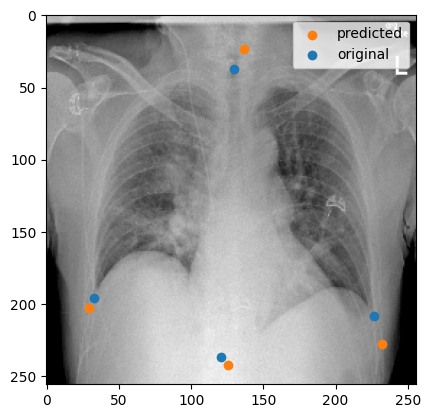

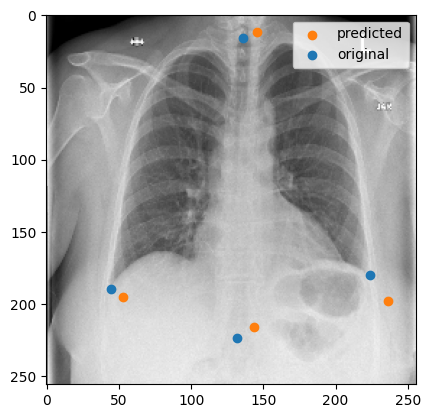

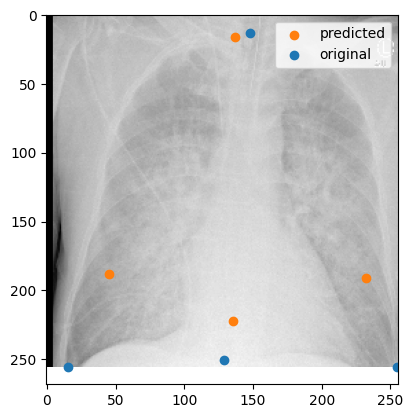

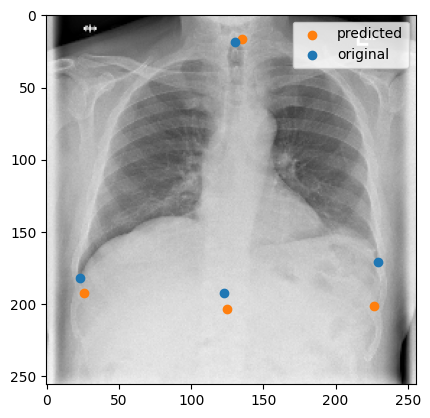

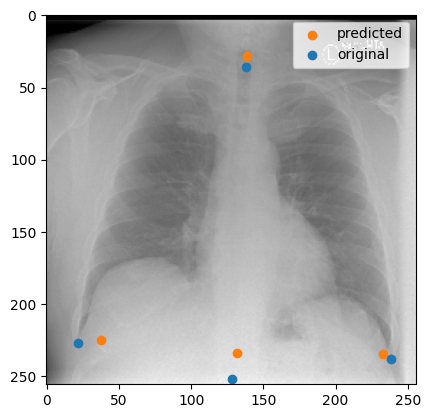

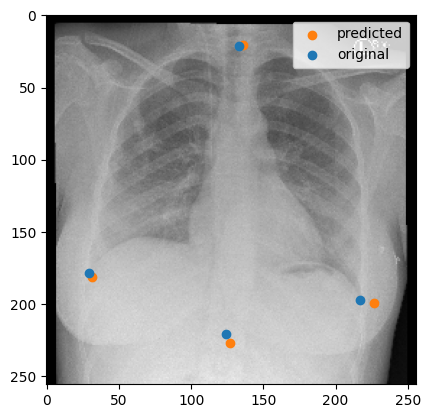

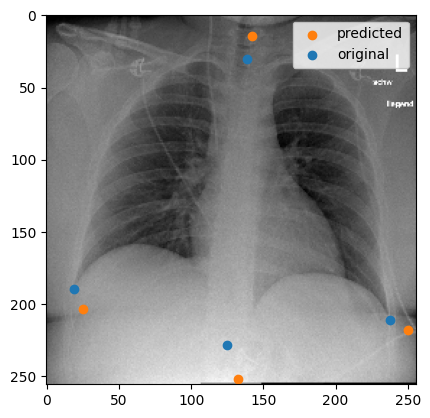

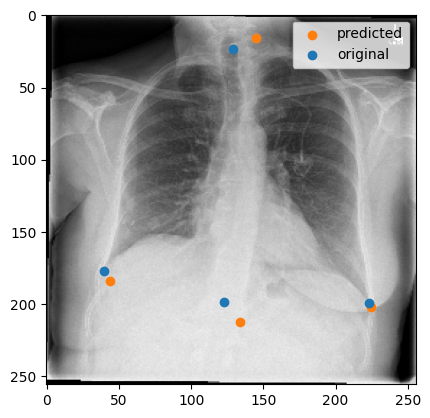

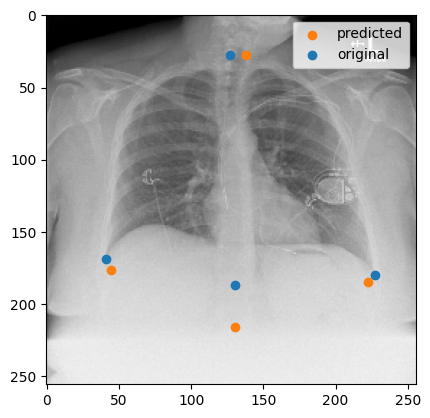

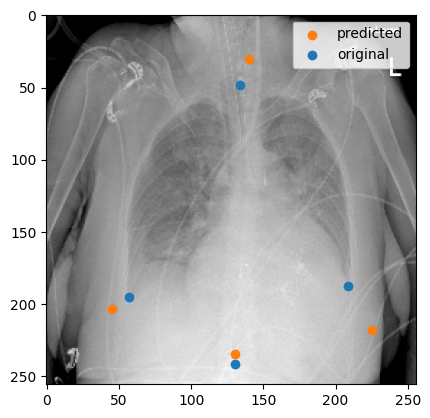

MSE: 180.86942138671876
Box IoU: 0.8044209937526755


In [6]:
loss_func = nn.MSELoss()

model.eval()
loss = 0
IoU = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()
print('MSE:', loss.item()/len(test_loader))
print('Box IoU:', IoU.item()/len(test_loader.dataset))

del loss, pred, IoU, target, img
torch.cuda.empty_cache()  

[93.37088012695312, 197.16665649414062, 74.44892883300781, 40.905391693115234, 207.67193603515625, 147.366455078125, 15.37183666229248, 70.10708618164062, 97.29910278320312, 670.54736328125, 154.61216735839844, 26.523462295532227, 383.10992431640625, 150.17831420898438, 633.74853515625, 619.1771850585938, 108.86233520507812, 87.62080383300781, 480.3489074707031, 201.56504821777344, 155.26141357421875, 99.66304779052734, 438.7657470703125, 104.23626708984375, 127.16940307617188, 100.65826416015625, 98.54096984863281, 252.25872802734375, 27.070022583007812, 369.7236328125, 83.22897338867188, 206.30030822753906, 1374.7012939453125, 455.6273498535156, 198.93109130859375, 23.169822692871094, 69.10391998291016, 65.37618255615234, 112.46810150146484, 282.33135986328125, 275.6375427246094, 102.11022186279297, 57.039180755615234, 280.5228271484375, 164.46762084960938, 155.1092529296875, 44.12834167480469, 133.0120391845703, 150.99481201171875, 101.857421875, 105.99861907958984, 130.061935424804

(array([10., 11., 21., 21., 19., 14.,  8.,  8.,  2.,  5.,  7.,  4.,  0.,
         6.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  14.98803902,   42.18230412,   69.37656921,   96.57083431,
         123.76509941,  150.95936451,  178.15362961,  205.34789471,
         232.54215981,  259.7364249 ,  286.93069   ,  314.1249551 ,
         341.3192202 ,  368.5134853 ,  395.7077504 ,  422.9020155 ,
         450.09628059,  477.29054569,  504.48481079,  531.67907589,
         558.87334099,  586.06760609,  613.26187119,  640.45613628,
         667.65040138,  694.84466648,  722.03893158,  749.23319668,
         776.42746178,  803.62172688,  830.81599197,  858.01025707,
         885.20452217,  912.39878727,  939.59305237,  966.78731747,
         993.98158257, 1021.17584766, 1048.37011276, 1075.56437786,
        1102.75864296, 1129.95290806

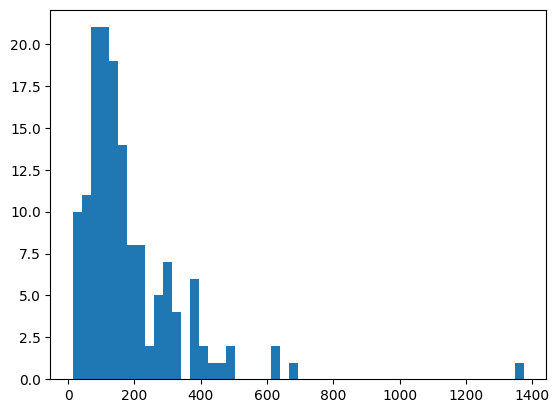

In [7]:
model.eval()
loss = []
for image, targ in test_loader:
        for i in range(image.shape[0]):
            img = image[i].to(device = DEVICE).unsqueeze(0)
            target = targ[i].to(DEVICE)
            pred = model(img)
            loss.append(loss_func(pred, target.unsqueeze(0).squeeze(1)).item())
print(loss)
plt.hist(loss, bins = 50)

Plot highes loss

In [8]:
from fixpoint_utils import get_test_dataset

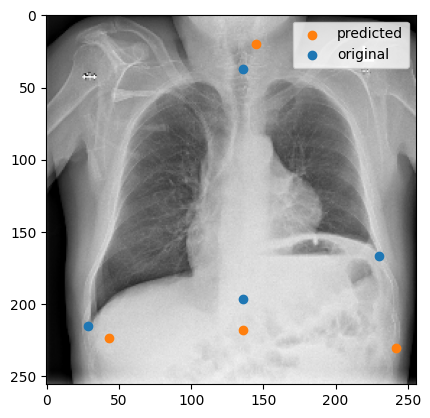

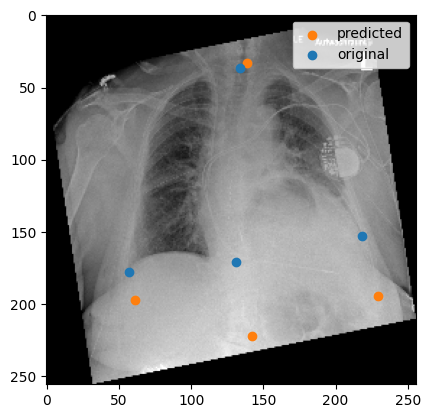

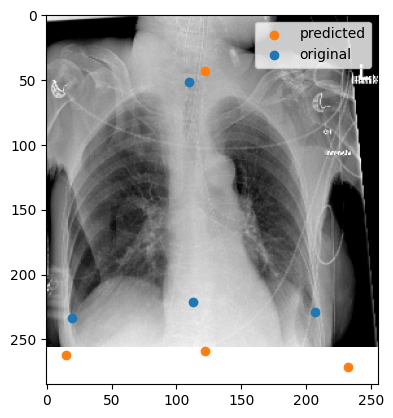

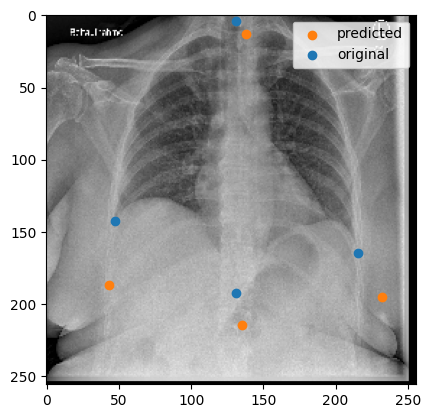

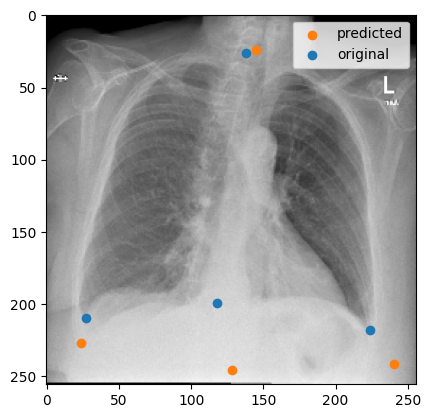

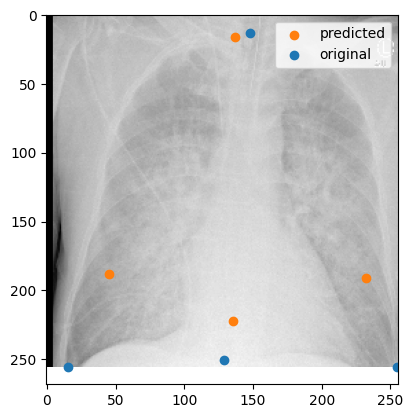

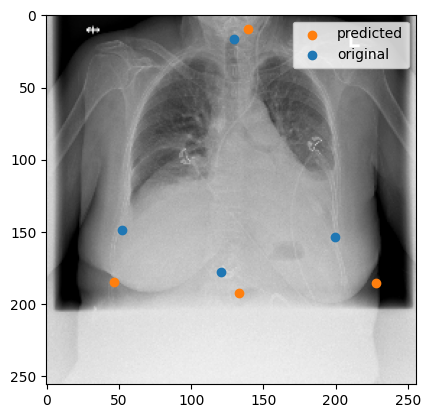

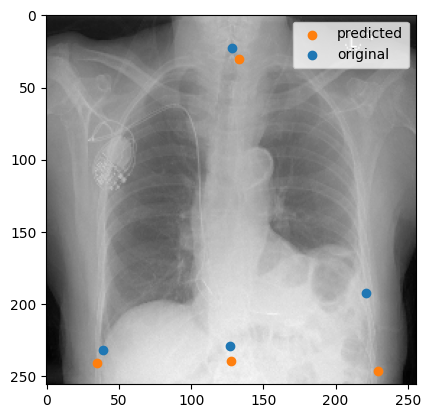

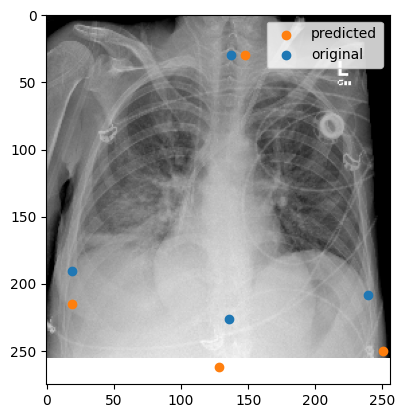

In [9]:
indexes = [i for i, loss in enumerate(loss) if loss > 400]
test_keypoint_ds = get_test_dataset()
subset = Subset(test_keypoint_ds, indexes)

subset_loader = DataLoader(subset,
                          batch_size= 1,
                          num_workers= 0,
                          pin_memory= False,
                          shuffle= False)

for image, kp in subset_loader:
    img = image.to(device = DEVICE)
    target = kp.to(DEVICE)
    pred = model(img)
    pred = pred[0].to('cpu').detach().numpy()
    plt.imshow(image[0][0], cmap='gray')
    for i in range(0, 8, 2):
        scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
        scatter2 = plt.scatter(kp[0,0,i], kp[0,0,i+1], color = 'C0')
    scatter1.set_label('predicted')
    scatter2.set_label('original')
    plt.legend()
    plt.show()